In [89]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'C:\Users\luukwouterse\Downloads\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [99]:
import importlib
import models
import advanced_dataloading
importlib.reload(advanced_dataloading)
importlib.reload(models)

<module 'models' from 'C:\\Users\\luukwouterse\\Downloads\\CapstoneAI-FiberProbe-main\\models.py'>

In [106]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import pickle

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data
from models import load_scalers, LSTMModel, GRUModel, CNNModel

gru1 = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1.load_state_dict(torch.load(path_to_output+"/models/gru23-5_2-20%3_is1_ns20_nl2_lr0.0025_ep11148_r20.997", map_location='cpu'))
gru1.eval()

gru2 = GRUModel(input_size=1, hidden_size=10, num_layers=3)
gru2.load_state_dict(torch.load(path_to_output+"/models/gru24-5_2-20%3_is1_ns10_nl3_lr0.0003_ep70000_r20.996", map_location='cpu'))
gru2.eval()

lstm = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm.load_state_dict(torch.load(path_to_output+"/models/lstm26-5_2-20%3_is1_ns18_nl2_lr0.001_ep150000_r20.998", map_location='cpu'))
lstm.eval()

cnn = CNNModel(input_channels=1, hidden_units=32, kernel_size=9, num_layers=7, input_length=600, output_size=1)
cnn.load_state_dict(torch.load(path_to_output+"/models/cnn27-5_2-20%3_ic1_hu32_ks9_nl7_lr0.0016_ep10000_r20.9987", map_location='cpu'))
cnn.eval()

with open(path_to_output+'/scalers/feature_scaler2-20%3_600.pkl', 'rb') as f:
    feature_scaler = pickle.load(f)

with open(path_to_output+'/scalers/target_scaler2-20%3_600.pkl', 'rb') as f:
    target_scaler = pickle.load(f)


In [100]:
df = process_folder(path_to_data, path_to_output, files=[3,7,12,18], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T145406
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 40, 'bin_file': '2024-11-08T145406.bin'}
836458000 datapoints extracted
LABELS: 586 bubble labels with VeloOut != -1 extracted.
No missing labels.
EXTRACTED: 586 bubbles have VeloOut != -1 out of 1736 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T145406    E0    -1 -1.000000   
1  1_2024-11-08T145406    E1    -1 -1.000000   
2  2_2024-11-08T145406    E2    L0  0.683543   
3  3_2024-11-08T145406    E3    -1 -1.000000   
4  4_2024-11-08T145406    E4    -1 -1.000000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5594042539596558, 0.5583666563034058, 0.561...        40  2.083333e+07  
1  [0.5815607309341431, 0.5836970210075378, 0.578...        40  2.083333e+07  
2  [0.616412878036499, 0.6122012734413147, 0.6301...        40  2.083333e+07  
3  [0.

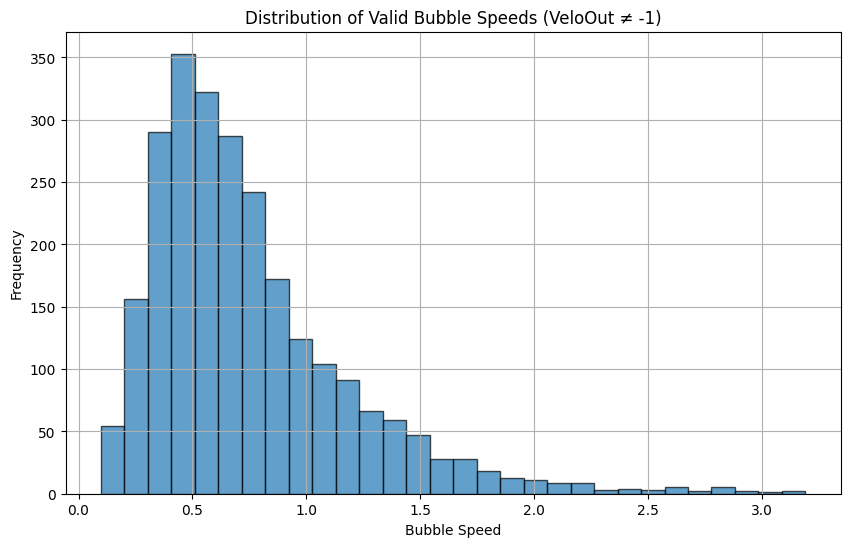

In [107]:
import matplotlib.pyplot as plt

# Filter out invalid speeds
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [122]:
X_array = np.vstack(df["VoltageOut"].to_numpy())  # shape: (samples, timesteps)
X_scaled = feature_scaler.transform(X_array)      # apply your trained scaler
X_tensor = torch.tensor(X_scaled[..., np.newaxis], dtype=torch.float32)  # shape: (samples, timesteps, 1)

with torch.no_grad():  
        y_gru1_scaled = gru1(X_tensor)
        y_gru2_scaled = gru2(X_tensor)
        y_lstm_scaled = lstm(X_tensor)
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2)/3).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100

print(outcome_df.head(10))

# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1(X_velo_scaled)
        y_gru2_scaled_velo = gru2(X_velo_scaled)
        y_lstm_scaled_velo = lstm(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo)/3).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
outcome_df_valid["abs_error"] = np.abs(outcome_df_valid["final prediction"] - y_velo) / y_velo
valid_test_results_10 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.1)
]
valid_test_results_5 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.05)
]
filtered_outcome_df = outcome_df_valid[outcome_df_valid['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results_10) / (len(outcome_df_valid)) * 100:.4f} %")
print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <5% from truth:  {len(valid_test_results_5) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100:.2f} % of the labled samples')


   predictions model 1  predictions model 2  predictions model 3  \
0             1.153293             2.982527             1.765862   
1             0.650190             0.823810             0.505699   
2             0.679299             0.675987             0.685786   
3             1.376675             1.717359             3.219801   
4             1.091665             1.072956             1.031621   
5             1.484669             1.381781             2.531834   
6             0.341196             0.338798             0.338567   
7             0.823083             0.811855             0.832009   
8             0.853573             0.852043             0.857621   
9             0.770022             0.768262             0.764315   

   final prediction  Standard deviation  Standard deviation %  
0          1.967227            0.931093             47.330235  
1          0.659900            0.159278             24.136684  
2          0.680357            0.004984              0.7325

In [119]:
X_array = np.vstack(df["VoltageOut"].to_numpy())  # shape: (samples, timesteps)
X_scaled = feature_scaler.transform(X_array)      # apply your trained scaler
X_tensor = torch.tensor(X_scaled[..., np.newaxis], dtype=torch.float32)  # shape: (samples, timesteps, 1)

with torch.no_grad():  
        y_gru1_scaled = gru1(X_tensor)
        y_gru2_scaled = gru2(X_tensor)
        y_lstm_scaled = lstm(X_tensor)
        y_cnn_scaled = cnn(X_tensor)
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn = target_scaler.inverse_transform(y_cnn_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2+y_cnn)/4).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "predictions model 4":y_cnn, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3","predictions model 4"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100

print(outcome_df.head(10))

# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1(X_velo_scaled)
        y_gru2_scaled_velo = gru2(X_velo_scaled)
        y_lstm_scaled_velo = lstm(X_velo_scaled)
        y_cnn_scaled_velo = cnn(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn_velo = target_scaler.inverse_transform(y_cnn_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo+y_cnn_velo)/4).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "predictions model 4":y_cnn_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3", "predictions model 4"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
outcome_df_valid["abs_error"] = np.abs(outcome_df_valid["final prediction"] - y_velo) / y_velo
valid_test_results_10 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.1)
]
valid_test_results_5 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.05)
]
filtered_outcome_df = outcome_df_valid[outcome_df_valid['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results_10) / (len(outcome_df_valid)) * 100:.4f} %")
print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <5% from truth:  {len(valid_test_results_5) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100:.2f} % of the labled samples')


   predictions model 1  predictions model 2  predictions model 3  \
0             1.153293             2.982527             1.765862   
1             0.650190             0.823810             0.505699   
2             0.679299             0.675987             0.685786   
3             1.376675             1.717359             3.219801   
4             1.091665             1.072956             1.031621   
5             1.484669             1.381781             2.531834   
6             0.341196             0.338798             0.338567   
7             0.823083             0.811855             0.832009   
8             0.853573             0.852043             0.857621   
9             0.770022             0.768262             0.764315   

   predictions model 4  final prediction  Standard deviation  \
0             1.698817          1.900125            0.771989   
1             0.533408          0.628277            0.144613   
2             0.685647          0.681680            0.00485

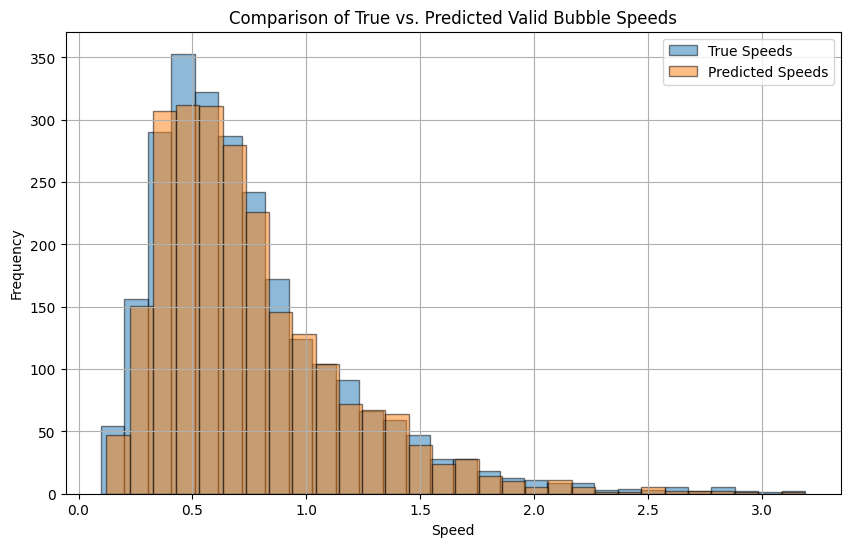

In [110]:
valid_df = df[df["VeloOut"] != -1]


# Match index if necessary
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = valid_test_results["final prediction"]
# Plot
plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="True Speeds", edgecolor='black')
plt.hist(predicted_valid_speeds, bins=30, alpha=0.5, label="Predicted Speeds", edgecolor='black')
plt.title("Comparison of True vs. Predicted Valid Bubble Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

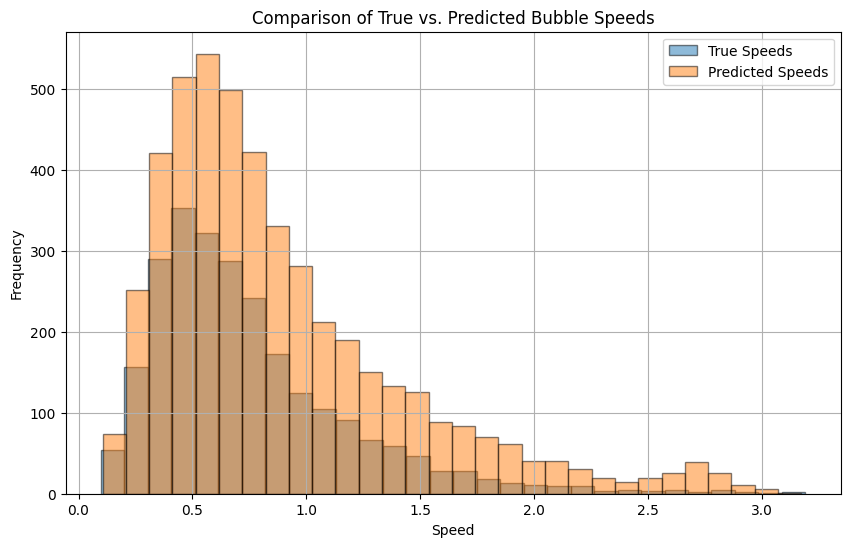

In [111]:
valid_df = df[df["VeloOut"] != -1]
cert_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]

# Match index if necessary
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = filtered_outcome_df["final prediction"]
predicted_speeds = cert_outcome_df["final prediction"]
# Plot
plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="True Speeds", edgecolor='black')
plt.hist(predicted_speeds, bins=30, alpha=0.5, label="Predicted Speeds", edgecolor='black')
plt.title("Comparison of True vs. Predicted Bubble Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
predicted_speeds.shape

(4724,)

In [113]:
valid_df.shape

(2510, 7)